In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
# img_to_array fonksiyonu görseli matrise çeviriyor
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.optimizers import Adam,RMSprop
import datetime
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import time
import pandas as pd
import numpy as np
import random

In [5]:
%load_ext tensorboard
# Clear any logs from previous runs
%rm -rf ./logs/

In [6]:
data_dir= "/content/gdrive/MyDrive/Kaggle/COVID-19 Radiography Database/"
covid_data_path = data_dir+"COVID-19/"
normal_data_path = data_dir+"NORMAL/"

In [7]:
img_height, img_width=224,224
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3,rotation_range=0.1,zoom_range=0.2,preprocessing_function=preprocess_input) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    color_mode="rgb") # set as training data
    
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    subset='validation') # set as validation data

validation_generator.class_indices

Found 1740 images belonging to 2 classes.
Found 744 images belonging to 2 classes.


{'COVID-19': 0, 'NORMAL': 1}

In [8]:
base_model= ResNet50(include_top=False,weights="imagenet")
x= base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64,activation="relu")(x)
x = Dropout(0.1)(x)
predictions= Dense(1,activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layers in base_model.layers:
    layers.trainable = False
    
# Defining optimizer
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
start=time.time()
trainer=model.fit(train_generator,validation_data=validation_generator,epochs=5,callbacks=[tensorboard_callback])
stop = time.time()
print("Resnet50 modelinin eğitim süresi : ",stop-start)

Epoch 1/5
109/109 [==============================] - 54s 453ms/step - loss: 0.2163 - accuracy: 0.9160 - val_loss: 0.0353 - val_accuracy: 0.9906
Epoch 2/5
109/109 [==============================] - 48s 439ms/step - loss: 0.0319 - accuracy: 0.9879 - val_loss: 0.0170 - val_accuracy: 0.9933
Epoch 3/5
109/109 [==============================] - 48s 438ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.0134 - val_accuracy: 0.9933
Epoch 4/5
109/109 [==============================] - 48s 441ms/step - loss: 0.0172 - accuracy: 0.9941 - val_loss: 0.0235 - val_accuracy: 0.9933
Epoch 5/5
109/109 [==============================] - 48s 440ms/step - loss: 0.0186 - accuracy: 0.9915 - val_loss: 0.0152 - val_accuracy: 0.9946
Resnet50 modelinin eğitim süresi :  255.00428104400635


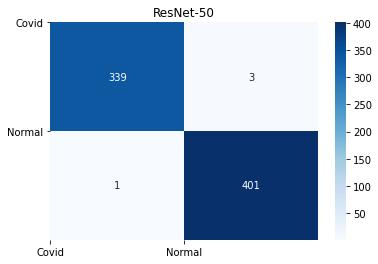

740


In [10]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
nb_samples = len(validation_generator)
y_pred = []
y_act=[]
p=0
for i in range(nb_samples):
  x,y=validation_generator.next()
  y_act.append(y)
  if model.predict(x)>0.5:
    y_pred.append(1)
  else : y_pred.append(0)
  if y_pred[i]==y_act[i]:
    p+=1
cm=confusion_matrix(y_act,y_pred)

sn.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.xticks([0,1], ["Covid","Normal"])
plt.yticks([0,1], ["Covid","Normal"],rotation=0)
plt.title("ResNet-50")
plt.show()
print(p)

In [11]:
names= ['Covid-19','Sağlıklı']
print(classification_report(y_act, y_pred, target_names=names))


              precision    recall  f1-score   support

    Covid-19       1.00      0.99      0.99       342
    Sağlıklı       0.99      1.00      1.00       402

    accuracy                           0.99       744
   macro avg       0.99      0.99      0.99       744
weighted avg       0.99      0.99      0.99       744

